<a href="https://colab.research.google.com/github/ngupta23/medium_articles/blob/main/time_series/pycaret/pycaret_ts_arima_010_0000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previous Article(s) in this Series
* [A Practical Guide to ARIMA Models using PyCaret — Part 1 (Statistical Overview)](https://towardsdatascience.com/understanding-arima-models-using-pycarets-time-series-module-part-1-692e10ca02f2)
* [A Practical Guide to ARIMA Models using PyCaret — Part 2 (Understanding the Trend Term)](https://towardsdatascience.com/understanding-arima-models-using-pycarets-time-series-module-part2-308ea7bfecf6)

## Install & Import Library




In [1]:
try:
  import pycaret
except:
  !pip install pycaret-ts-alpha

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from pycaret.datasets import get_data
from pycaret.internal.pycaret_experiment import TimeSeriesExperiment
from sklearn.linear_model import LinearRegression

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Get Data and Setup PyCaret Experiment

In [3]:
#### Get data from data playground ----
y = get_data("1", folder="time_series/random_walk")

,x
0,186.268370
1,186.310486
2,185.399564
3,185.557593
4,184.903008


In [4]:
exp = TimeSeriesExperiment()
exp.setup(data=y, seasonal_period=1, fh=30, session_id=42)

,Description,Value
0,session_id,42
1,Original Data,"(340, 1)"
2,Missing Values,False
3,Transformed Train Set,"(310,)"
4,Transformed Test Set,"(30,)"
5,Fold Generator,ExpandingWindowSplitter
6,Fold Number,3
7,Enforce Prediction Interval,False
8,Seasonal Period Tested,1
9,Seasonality Detected,False


## EDA

In [5]:
exp.plot_model()

In [6]:
exp.plot_model(plot="acf")
exp.plot_model(plot="pacf")

## Helper functions using PyCaret's Time Series Module

In [7]:
def summarize_model(model):
  """
  Provides statistical summary for some statistical models
  """
  # Statistical Summary Table
  try:
    print(model.summary())
  except:
    print("Summary does not exist for this model.")

In [8]:
def get_residual_properties(model):
  """
  Plots and displays variance of residuals
  """
  #### Residuals ----
  try:
    plot_data = exp.plot_model(model, plot="residuals", return_data=True)
    resid = plot_data['data']
    resid_sigma2 = (resid**2).sum()/(len(resid))
    print(f"Residual Sigma 2: {resid_sigma2}")
  except:
    print("Residuals can not be extracted for this model.")

In [9]:
def plot_predictions(model):
  """
  Plots out-of-sample and in-sample predictions
  """
  # Out-of-Sample Forecast
  exp.plot_model(model)
  
  # In-Sample Forecast
  exp.plot_model(model, plot="insample")

## Train & Test Data Properties

In [10]:
# Get Train Data Properties
y_train = exp.get_config("y_train")
print(f"Train Start Index: {y_train.index.min()}\nTrain End Index: {y_train.index.max()}")

# Get Test Data Properties
y_test = exp.get_config("y_test")
print(f"Test Start Index: {y_test.index.min()}\nTest End Index: {y_test.index.max()}")

Train Start Index: 0
Train End Index: 309
Test Start Index: 310
Test End Index: 339


## Random Walk ARIMA Model

### Theoretical Calculations

#### Random Walk without Trend

In [11]:
train_data = pd.DataFrame({"y":y_train})
train_data['preds'] = y_train.shift(1)
train_data['split'] = "Train"

test_data = pd.DataFrame({'y': y_test})
test_data['preds'] = y_train.iloc[-1]
test_data['split'] = "Test"

data = pd.concat([train_data, test_data])
data['residuals'] = data['y'] - data['preds']
data.reset_index(inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      340 non-null    int64  
 1   y          340 non-null    float64
 2   preds      339 non-null    float64
 3   split      340 non-null    object 
 4   residuals  339 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 13.4+ KB


[Text(0.5, 1.0, 'Theoretical Predictions')]

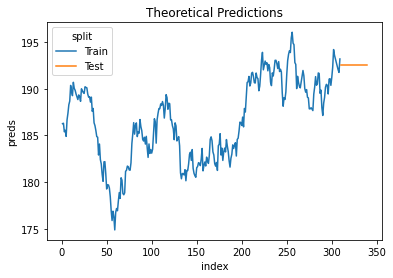

In [12]:
sns.lineplot(data=data, x="index", y="preds", hue="split").set(title="Theoretical Predictions")

#### Random Walk with trend = "c"

In [13]:
y_for_lr = data.query("split=='Train'")['residuals'].dropna()
y_for_lr.mean()

0.020172890811799432

#### Random Walk with trend = "t"

In [14]:
y_for_lr = data.query("split=='Train'")['residuals'].dropna()
X_train = np.arange(1, len(y_for_lr)+1).reshape(-1, 1)

reg = LinearRegression(fit_intercept=False).fit(X_train, y_for_lr)
print(f"Expected Intercept: {reg.intercept_}")
print(f"Expected Slope: {reg.coef_}")

Expected Intercept: 0.0
Expected Slope: [0.00018524]


#### Random Walk with trend = "ct"

In [15]:
y_for_lr = data.query("split=='Train'")['residuals'].dropna()
X_train = np.arange(1, len(y_for_lr)+1).reshape(-1, 1)

reg = LinearRegression(fit_intercept=True).fit(X_train, y_for_lr)
print(f"Expected Intercept: {reg.intercept_}")
print(f"Expected Slope: {reg.coef_}")

Expected Intercept: -0.03432448539897173
Expected Slope: [0.0003516]


### Now let's build this model & compare to Theory

#### Random Walk without Trend

In [16]:
model3a = exp.create_model("arima", order=(0, 1, 0), seasonal_order=(0, 0, 0, 0), trend="n")

,cutoff,MAE,RMSE,MAPE,SMAPE,R2
0,219.0,1.8274,1.9904,0.0095,0.0096,-1.0221
1,249.0,2.1118,2.4533,0.0110,0.0110,-0.0227
2,279.0,1.9092,2.2795,0.0100,0.0100,-0.9045
Mean,NaN,1.9495,2.2411,0.0102,0.0102,-0.6498
SD,NaN,0.1196,0.1909,0.0006,0.0006,0.4460


In [17]:
summarize_model(model3a)
get_residual_properties(model3a)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  310
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -435.205
Date:                Fri, 26 Nov 2021   AIC                            872.410
Time:                        14:22:43   BIC                            876.143
Sample:                             0   HQIC                           873.902
                                - 310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9792      0.080     12.203      0.000       0.822       1.136
Ljung-Box (L1) (Q):                   0.99   Jarque-Bera (JB):                 0.16
Prob(Q):                              0.32   Pr

Residual Sigma 2: 0.9792018904230774


In [18]:
plot_predictions(model3a)

In [19]:
exp.check_stats(model3a, test="white_noise")

,Test,Test Name,Property,Setting,Value
0,White Noise,Ljung-Box,Test Statictic,"{'alpha': 0.05, 'K': 24}",27.9957
1,White Noise,Ljung-Box,Test Statictic,"{'alpha': 0.05, 'K': 48}",46.0732
2,White Noise,Ljung-Box,p-value,"{'alpha': 0.05, 'K': 24}",0.260223
3,White Noise,Ljung-Box,p-value,"{'alpha': 0.05, 'K': 48}",0.552117
4,White Noise,Ljung-Box,White Noise,"{'alpha': 0.05, 'K': 24}",True
5,White Noise,Ljung-Box,White Noise,"{'alpha': 0.05, 'K': 48}",True


#### Random Walk with trend = "c"

In [20]:
model3b = exp.create_model("arima", order=(0, 1, 0), seasonal_order=(0, 0, 0, 0), trend="c")

,cutoff,MAE,RMSE,MAPE,SMAPE,R2
0,219.0,1.7202,1.8788,0.0090,0.0090,-0.8017
1,249.0,2.3373,2.6818,0.0122,0.0122,-0.2221
2,279.0,1.7762,2.1185,0.0093,0.0093,-0.6450
Mean,NaN,1.9446,2.2264,0.0102,0.0102,-0.5563
SD,NaN,0.2786,0.3366,0.0015,0.0014,0.2448


In [21]:
summarize_model(model3b)
get_residual_properties(model3b)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  310
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -435.141
Date:                Fri, 26 Nov 2021   AIC                            874.281
Time:                        14:22:44   BIC                            881.748
Sample:                             0   HQIC                           877.266
                                - 310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0202      0.056      0.358      0.720      -0.090       0.131
sigma2         0.9788      0.080     12.208      0.000       0.822       1.136
Ljung-Box (L1) (Q):                   0.99   Jarque-

Residual Sigma 2: 0.9787949448993141


In [22]:
plot_predictions(model3b)

In [23]:
exp.check_stats(model3b, test="white_noise")

,Test,Test Name,Property,Setting,Value
0,White Noise,Ljung-Box,Test Statictic,"{'alpha': 0.05, 'K': 24}",27.9957
1,White Noise,Ljung-Box,Test Statictic,"{'alpha': 0.05, 'K': 48}",46.0732
2,White Noise,Ljung-Box,p-value,"{'alpha': 0.05, 'K': 24}",0.260223
3,White Noise,Ljung-Box,p-value,"{'alpha': 0.05, 'K': 48}",0.552117
4,White Noise,Ljung-Box,White Noise,"{'alpha': 0.05, 'K': 24}",True
5,White Noise,Ljung-Box,White Noise,"{'alpha': 0.05, 'K': 48}",True


#### Random Walk with trend = "t"

In [24]:
model3c = exp.create_model("arima", order=(0, 1, 0), seasonal_order=(0, 0, 0, 0), with_intercept=True, trend='t')
model3c

,cutoff,MAE,RMSE,MAPE,SMAPE,R2
0,219.0,1.5477,1.9237,0.0081,0.0081,-0.8889
1,249.0,2.9862,3.4021,0.0157,0.0156,-0.9667
2,279.0,1.4886,1.7826,0.0078,0.0078,-0.1647
Mean,NaN,2.0075,2.3695,0.0105,0.0105,-0.6734
SD,NaN,0.6925,0.7324,0.0037,0.0036,0.3611


ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend='t',
      with_intercept=True)

In [25]:
summarize_model(model3c)
get_residual_properties(model3c)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  310
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -435.032
Date:                Fri, 26 Nov 2021   AIC                            874.063
Time:                        14:22:46   BIC                            881.530
Sample:                             0   HQIC                           877.048
                                - 310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0002      0.000      0.582      0.560      -0.000       0.001
sigma2         0.9781      0.080     12.197      0.000       0.821       1.135
Ljung-Box (L1) (Q):                   1.02   Jarque-

Residual Sigma 2: 0.9781044589801151


In [26]:
plot_predictions(model3c)

In [27]:
exp.check_stats(model3c, test="white_noise")

,Test,Test Name,Property,Setting,Value
0,White Noise,Ljung-Box,Test Statictic,"{'alpha': 0.05, 'K': 24}",28.1453
1,White Noise,Ljung-Box,Test Statictic,"{'alpha': 0.05, 'K': 48}",46.3326
2,White Noise,Ljung-Box,p-value,"{'alpha': 0.05, 'K': 24}",0.253958
3,White Noise,Ljung-Box,p-value,"{'alpha': 0.05, 'K': 48}",0.541368
4,White Noise,Ljung-Box,White Noise,"{'alpha': 0.05, 'K': 24}",True
5,White Noise,Ljung-Box,White Noise,"{'alpha': 0.05, 'K': 48}",True


#### Random Walk with trend = "ct"

In [28]:
model3d = exp.create_model("arima", order=(0, 1, 0), seasonal_order=(0, 0, 0, 0), trend="ct")

,cutoff,MAE,RMSE,MAPE,SMAPE,R2
0,219.0,1.7743,2.3436,0.0093,0.0093,-1.8035
1,249.0,3.4014,3.9197,0.0179,0.0177,-1.6107
2,279.0,1.3269,1.6169,0.0069,0.0070,0.0417
Mean,NaN,2.1675,2.6267,0.0114,0.0113,-1.1241
SD,NaN,0.8914,0.9612,0.0047,0.0046,0.8281


In [29]:
summarize_model(model3d)
get_residual_properties(model3d)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  310
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -434.985
Date:                Fri, 26 Nov 2021   AIC                            875.971
Time:                        14:22:48   BIC                            887.171
Sample:                             0   HQIC                           880.448
                                - 310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0343      0.117     -0.292      0.770      -0.264       0.196
drift          0.0004      0.001      0.530      0.596      -0.001       0.002
sigma2         0.9778      0.081     12.141      0.0

Residual Sigma 2: 0.9778113439140794


In [30]:
plot_predictions(model3d)

In [31]:
exp.check_stats(model3d, test="white_noise")

,Test,Test Name,Property,Setting,Value
0,White Noise,Ljung-Box,Test Statictic,"{'alpha': 0.05, 'K': 24}",28.2088
1,White Noise,Ljung-Box,Test Statictic,"{'alpha': 0.05, 'K': 48}",46.4439
2,White Noise,Ljung-Box,p-value,"{'alpha': 0.05, 'K': 24}",0.251333
3,White Noise,Ljung-Box,p-value,"{'alpha': 0.05, 'K': 48}",0.536759
4,White Noise,Ljung-Box,White Noise,"{'alpha': 0.05, 'K': 24}",True
5,White Noise,Ljung-Box,White Noise,"{'alpha': 0.05, 'K': 48}",True


The calculations match exactly with the theoretical calculations. Hopefully this exercise has given us a good understanding of the `d` component of the ARIMA model. In the next set of articles, we will cover the remaining parameters in the ARIMA model.